# [01] Assignment 1

## (1) State Value Evaluation V(s)
Compute the value of each state 𝑉(𝑠) under the given environment, assuming a discount factor of γ = 0.85

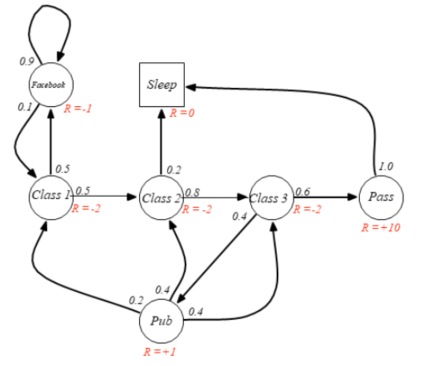

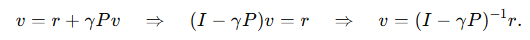

In [ ]:
import numpy as np

In [ ]:
def expected_state_rewards_from_transition_rewards(P, R):
    """
    Convert transition-based rewards R[s, s'] to state-based rewards r[s] = E[R | s].
    P: (n, n) transition matrix
    R: (n, n) transition rewards, where R[s, s'] is the reward when moving s -> s'
    Returns: r vector of length n
    """
    P = np.asarray(P, dtype=float)
    R = np.asarray(R, dtype=float)
    assert P.shape == R.shape and P.ndim == 2 and P.shape[0] == P.shape[1]
    return (P * R).sum(axis=1)

In [ ]:
def value_function_closed_form(P, r, gamma):
    """
    Solve (I - gamma * P) v = r for v.
    Uses a linear solve (more stable than matrix inverse).
    """
    P = np.asarray(P, dtype=float)
    r = np.asarray(r, dtype=float)
    n = P.shape[0]
    assert P.shape == (n, n)
    assert r.shape == (n, )
    I = np.eye(n)
    A = I - gamma * P
    v = np.linalg.solve(A, r)
    return v

In [ ]:
def value_function_iterative(P, r, gamma, tol=1e-10, max_iter=1000000):
    """
    Fixed-point iteration: v_{k+1} = r + gamma * P  v_{k}
    Stops when || v_{k+1} - v{k} || _inf < tol, or max_iter reached.
    """
    P = np.asarray(P, dtype=float)
    r = np.asarray(r, dtype=float)
    n = P.shape[0]
    v = np.zeros(n, dtype=float)
    for it in range(max_iter):
        v_next = r + gamma * P @ v
        if np.max(np.abs(v_next - v)) < tol:
            return v_next
        v = v_next
    # If not converged, still return the last iterate
    return v

In [ ]:
# Transition matrix P (rows sum to 1).
P = np.array([
    [0.0, 0.5, 0.0, 0.0, 0.5, 0.0, 0.0], # C1
    [0.0, 0.0, 0.8, 0.0, 0.0, 0.2, 0.0], # C2
    [0.0, 0.0, 0.0, 0.6, 0.0, 0.0, 0.4], # C3
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], # Pass
    [0.1, 0.0, 0.0, 0.0, 0.9, 0.0, 0.0], # Facebook
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], # Sleap
    [0.2, 0.4, 0.4, 0.0, 0.0, 0.0, 0.0], # Pub
], dtype=float)

In [ ]:
# State rewards r (per time-step in each state). Terminal reward is 0 by convention.
r = np.array([-2, -2, -2, 10, -1, 0, 1], dtype=float)

# If your rewards are transition-based, provide R and derive r like this:
# R = np.zeros_like(P)  # fill R[s, s'] as needed
# r = expected_state_rewards_from_transition_rewards(P, R)

In [ ]:
gamma = 0.85

In [ ]:
# Compute values
v_closed = value_function_closed_form(P, r, gamma)
v_iter = value_function_iterative(P, r, gamma, tol=1e-12)

In [ ]:
# Sanity checks
bellman_residual = np.linalg.norm(v_closed - (r + gamma * P @ v_closed), ord=np.inf)
diff_methds = np.linalg.norm(v_closed - v_iter, ord=np.inf)

print("Value function (closed-form):\n", v_closed)
print('\nValue function (iterative):\n', v_iter)
print(f"\nBellman residual (∞-norm): {bellman_residual:.3e}")
print(f"Closed-form vs Iterative difference (∞-norm): {diff_methds:.3e}")

Value function (closed-form):
 [-4.24889944  0.50062703  3.67739269 10.         -5.79215512 -0.
  1.6982138 ]

Value function (iterative):
 [-4.24889944  0.50062703  3.67739269 10.         -5.79215512  0.
  1.6982138 ]

Bellman residual (∞-norm): 1.110e-15
Closed-form vs Iterative difference (∞-norm): 3.952e-12


## (2) Action Value Evaluation Q(s, a)
Calculate the action-value function 𝑄(𝑠,𝑎) for each state–action pair, with the same discount factor γ = 0.85.

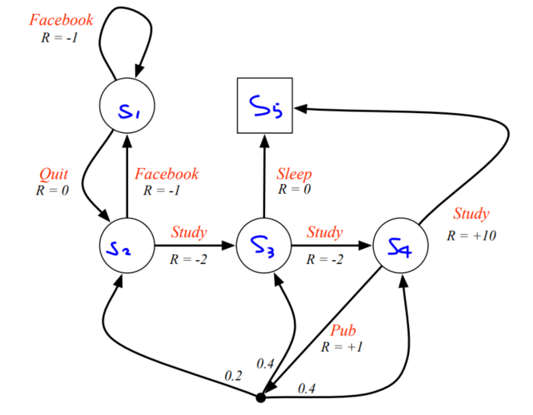

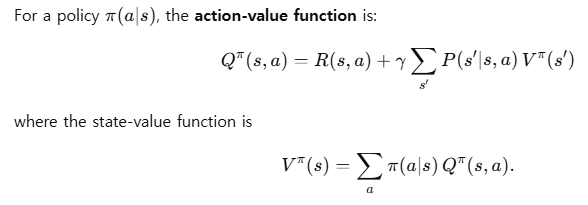

In [ ]:
import numpy as np

def expected_q_value(P, R, pi, gamma=0.95, tol=1e-8, max_iter=100000):
    """
    Compute expected Q^pi(s,a) given a fixed policy pi.

    Parameters
    ----------
    P : dict
        Transition probabilities: P[s][a] = [(prob, next_state), ...]
    R : dict
        Rewards: R[s][a] = reward for taking action a in state s
    pi : dict
        Policy: pi[s][a] = probability of taking action a in state s
    gamma : float
        Discount factor
    tol : float
        Convergence tolerance
    max_iter : int
        Maximum iterations

    Returns
    -------
    Q : np.ndarray
        Expected Q-function under policy pi
    V : np.ndarray
        Expected V-function under policy pi
    """
    n_states = len(P)
    n_actions = max(len(P[s]) for s in P)
    Q = np.zeros((n_states, n_actions))

    for it in range(max_iter):
        delta = 0
        for s in range(n_states):
            for a in P[s]:
                reward = R[s][a]
                expected_value = 0
                for prob, s_next in P[s][a]:
                    # use policy expectation, not max
                    expected_value += prob * sum(
                        pi[s][a_next] * Q[s_next][a_next] for a_next in P[s_next]
                    )
                q_new = reward + gamma * expected_value
                delta = max(delta, abs(q_new - Q[s][a]))
                Q[s][a] = q_new
        if delta < tol:
            break

    V = np.array([sum(pi[s][a] * Q[s][a] for a in P[s]) for s in range(n_states)])
    return Q, V

In [ ]:
P = {
    0 : {0: [(1.0, 0)], 1: [(1.0, 1)]},
    1 : {0: [(1.0, 0)], 2: [(1.0, 2)]},
    2 : {2: [(1.0, 3)], 3: [(1.0, 4)]},
    3 : {2: [(1.0, 4)], 4: [(0.2, 1), (0.4, 2), (0.4, 3)]},
    4 : {0: [(1.0, 4)], 1: [(1.0, 4)], 2: [(1.0, 4)], 3: [(1.0, 4)], 4: [(1.0, 4)]},
}

R = {
    0 : {0: -1, 1: 0},
    1 : {0: -1, 2: -2},
    2 : {2: -2, 3: 0},
    3 : {2: 10, 4: 1},
    4 : {0: 0, 1: 0, 2: 0, 3: 0, 4: 0},
}

# Policy: uniform random over available actions
pi = {
    0 : {0:0.5, 1:0.5, 2:0.0, 3:0.0, 4:0.0},
    1 : {0:0.5, 1:0.0, 2:0.5, 3:0.0, 4:0.0},
    2 : {0:0.0, 1:0.0, 2:0.5, 3:0.5, 4:0.0},
    3 : {0:0.0, 1:0.0, 2:0.5, 3:0.0, 4:0.5},
    4 : {0:0.0, 1:00.0, 2:0.0, 3:0.0, 4:0.0},
}

gamma = 0.85

Q_pi, V_pi = expected_q_value(P, R, pi, gamma)

print("Expected Q^pi:\n", Q_pi)
print("\nExpected V^pi:\n", V_pi)

Expected Q^pi:
 [[-2.3696177  -0.8530122   0.          0.          0.        ]
 [-2.00708752  0.         -1.04375     0.          0.        ]
 [ 0.          0.          2.25        0.          0.        ]
 [ 0.          0.         10.          0.          3.60696536]
 [ 0.          0.          0.          0.          0.        ]]

Expected V^pi:
 [-1.61131495 -1.52541876  1.125       6.80348268  0.        ]


In [ ]:
gamma = 1

Q_pi, V_pi = expected_q_value(P, R, pi, gamma)

print("\nExpected V^pi:\n", V_pi)


Expected V^pi:
 [-2.33333332 -1.58333333  1.5         7.21875     0.        ]


## (3) How many iterations of value iteration are required to reach the final (converged) value function?

In [ ]:
import numpy as np

def value_function_iterative(P, r, gamma, tol=1e-10, max_iter=1000000):
    """
    Fixed-point iteration: v_{k+1} = r + gamma * P @ v_{k}
    Stops when || v_{k+1} - v{k} || _inf < tol, or max_iter reached.
    """
    P = np.asarray(P, dtype=float)
    r = np.asarray(r, dtype=float)
    n = P.shape[0]
    v = np.zeros(n, dtype=float)

    for it in range(max_iter):
        v_next = r + gamma * P @ v
        print(f"Iter: {it}")
        print(v_next)
        print("----------------------------------------------------------------")
        if np.max(np.abs(v_next - v)) < tol:
            print(f"Value iteration converged at iter {it}.")
            return v_next
        v = v_next
    return v

In [ ]:
# Transition matrix P (rows sum to 1).
P = np.array([
    [0.0, 0.5, 0.0, 0.0, 0.5, 0.0, 0.0], # C1
    [0.0, 0.0, 0.8, 0.0, 0.0, 0.2, 0.0], # C2
    [0.0, 0.0, 0.0, 0.6, 0.0, 0.0, 0.4], # C3
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], # Pass
    [0.1, 0.0, 0.0, 0.0, 0.9, 0.0, 0.0], # Facebook
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], # Sleap
    [0.2, 0.4, 0.4, 0.0, 0.0, 0.0, 0.0], # Pub
], dtype=float)

# State rewards r (per time-step in each state). Terminal reward is 0 by convention.
r = np.array([-2, -2, -2, 10, -1, 0, 1], dtype=float)

gamma = 0.85

tol = 1e-10

v_iter = value_function_iterative(P, r, gamma, tol=tol)
print('\nValue function (iterative):\n', v_iter)

Iter: 0
[-2. -2. -2. 10. -1.  0.  1.]
----------------------------------------------------------------
Iter: 1
[-3.275 -3.36   3.44  10.    -1.935  0.    -0.7  ]
----------------------------------------------------------------
Iter: 2
[-4.250375  0.3392    2.862    10.       -2.75865   0.        0.47045 ]
----------------------------------------------------------------
Iter: 3
[-3.02826625 -0.05384     3.259953   10.         -3.47164913  0.
  1.36584425]
----------------------------------------------------------------
Iter: 4
[-3.49833288  0.21676804  3.56438704 10.         -3.91321421  0.
  1.57527316]
----------------------------------------------------------------
Iter: 5
[-3.57098962  0.42378319  3.63559287 10.         -4.29096717  0.
  1.69087614]
----------------------------------------------------------------
Iter: 6
[-3.64355319  0.47220315  3.67489789 10.         -4.586124    0.
  1.77311963]
----------------------------------------------------------------
Iter: 7
[-3.74841636

In [ ]:
tol = 1e-6

v_iter = value_function_iterative(P, r, gamma, tol=tol)
print('\nValue function (iterative):\n', v_iter)

Iter: 0
[-2. -2. -2. 10. -1.  0.  1.]
----------------------------------------------------------------
Iter: 1
[-3.275 -3.36   3.44  10.    -1.935  0.    -0.7  ]
----------------------------------------------------------------
Iter: 2
[-4.250375  0.3392    2.862    10.       -2.75865   0.        0.47045 ]
----------------------------------------------------------------
Iter: 3
[-3.02826625 -0.05384     3.259953   10.         -3.47164913  0.
  1.36584425]
----------------------------------------------------------------
Iter: 4
[-3.49833288  0.21676804  3.56438704 10.         -3.91321421  0.
  1.57527316]
----------------------------------------------------------------
Iter: 5
[-3.57098962  0.42378319  3.63559287 10.         -4.29096717  0.
  1.69087614]
----------------------------------------------------------------
Iter: 6
[-3.64355319  0.47220315  3.67489789 10.         -4.586124    0.
  1.77311963]
----------------------------------------------------------------
Iter: 7
[-3.74841636

In [ ]:
tol = 1e-4

v_iter = value_function_iterative(P, r, gamma, tol=tol)
print('\nValue function (iterative):\n', v_iter)

Iter: 0
[-2. -2. -2. 10. -1.  0.  1.]
----------------------------------------------------------------
Iter: 1
[-3.275 -3.36   3.44  10.    -1.935  0.    -0.7  ]
----------------------------------------------------------------
Iter: 2
[-4.250375  0.3392    2.862    10.       -2.75865   0.        0.47045 ]
----------------------------------------------------------------
Iter: 3
[-3.02826625 -0.05384     3.259953   10.         -3.47164913  0.
  1.36584425]
----------------------------------------------------------------
Iter: 4
[-3.49833288  0.21676804  3.56438704 10.         -3.91321421  0.
  1.57527316]
----------------------------------------------------------------
Iter: 5
[-3.57098962  0.42378319  3.63559287 10.         -4.29096717  0.
  1.69087614]
----------------------------------------------------------------
Iter: 6
[-3.64355319  0.47220315  3.67489789 10.         -4.586124    0.
  1.77311963]
----------------------------------------------------------------
Iter: 7
[-3.74841636

In [ ]:
tol = 1e-3

v_iter = value_function_iterative(P, r, gamma, tol=tol)
print('\nValue function (iterative):\n', v_iter)

Iter: 0
[-2. -2. -2. 10. -1.  0.  1.]
----------------------------------------------------------------
Iter: 1
[-3.275 -3.36   3.44  10.    -1.935  0.    -0.7  ]
----------------------------------------------------------------
Iter: 2
[-4.250375  0.3392    2.862    10.       -2.75865   0.        0.47045 ]
----------------------------------------------------------------
Iter: 3
[-3.02826625 -0.05384     3.259953   10.         -3.47164913  0.
  1.36584425]
----------------------------------------------------------------
Iter: 4
[-3.49833288  0.21676804  3.56438704 10.         -3.91321421  0.
  1.57527316]
----------------------------------------------------------------
Iter: 5
[-3.57098962  0.42378319  3.63559287 10.         -4.29096717  0.
  1.69087614]
----------------------------------------------------------------
Iter: 6
[-3.64355319  0.47220315  3.67489789 10.         -4.586124    0.
  1.77311963]
----------------------------------------------------------------
Iter: 7
[-3.74841636

# [02] Assignment 2


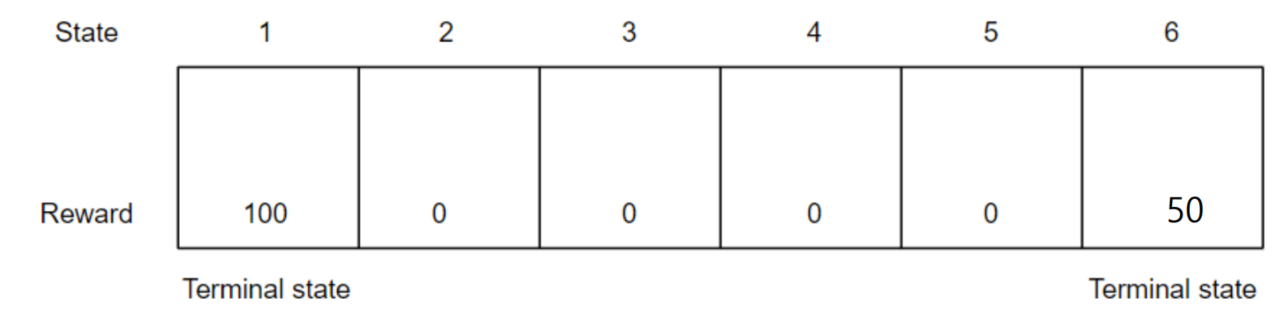

## (1) State Value Evaluation V(s)
Compute the value of each state 𝑉(𝑠) under the random walk environment, assuming a discount factor of γ = 1.0

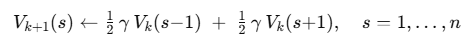

In [6]:
import numpy as np

def value_iteration_random_walk(n_states=4, left_reward=100.0, right_reward=50.0,
                                gamma=1.0, tol=1e-10, max_iter=1000000, verbose=False):
    """
    Value iteration for a 1D random walk with two terminal states.

    Layout:
        [0], ... [1] [2] ... [n_states] ... [n_states+1]
         ^ left terminal (value = left_reward) ^ right terminal (value = right_reward)

    Transitions (ramdom policy): from interior state s, move to s-1 or s+1 with prob 0.5 each.
    Non-terminal rewards are 0; terminal values are fixed at their rewards.
    """
    n = n_states
    # V includes terminals: size = n + 2
    V = np.zeros(n + 2, dtype=float)

    # Fix terminals to their rewards
    V[0] = left_reward
    V[-1] = right_reward

    for it in range(max_iter):
        V_old = V.copy()

        # Update interior states only
        for s in range(1, n+1):
            V[s] = 0.5 * (gamma * V_old[s-1]) + 0.5 * (gamma * V_old[s+1])

        # Convergence check (ignore terminals)
        delta = np.max(np.abs(V[1:-1] - V_old[1:-1]))
        if verbose and (it % 1000 == 0 or delta < tol):
            print(f"iter={it:6d}  delta={delta:.3e}")
        if delta < tol:
            break

    return V, it+1

In [7]:
if __name__=='__main__':
    V, iters = value_iteration_random_walk(
        n_states=4, left_reward=100.0, right_reward=50.0, gamma=1.0, tol=1e-12
    )
    print(f"Converged in {iters} iterations.")
    print("Value function (including terminals):")
    print(V)

Converged in 146 iterations.
Value function (including terminals):
[100.  90.  80.  70.  60.  50.]


In [5]:
# (Optional) closed-form check: linear interpolation between boundaries
n_states = 4
s = np.arange(n_states + 2)
V_lin = 100 + (s / (n_states + 1)) * (50 - 100)  # left + fraction * (right-left)
print("\nClosed-form (linear interpolation) for comparison:")
print(V_lin)


Closed-form (linear interpolation) for comparison:
[100.  90.  80.  70.  60.  50.]


## (2) Action Value Evaluation Q(s, a)
Compute the action value function Q(s, a) under the random walk environment, assuming a discount factor of γ = 1.0

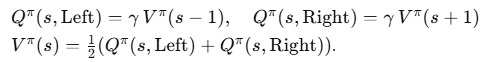

In [9]:
import numpy as np

def expected_q_random_policy(
        n_states=4, left_reward=100.0, right_reward=50.0,
        gamma=1.0, tol=1e-12, max_iter=1000000, verbose=False,
):
    """
    Policy evaluation for 1 1D random walk with two absorbing terminals,
    under a fixed random policy: pi(Left|s) = pi(Right|s) = 0.5 for interior states.

    Layout (indices):
        0, 1, 2, ..., n_states, n_states+1
        ^ left terminal                   ^ right terminal

    Returns
    --------
    Q: (n_states+2, 2) array
        Expected action-value function under the fixed random policy.
        Columns: 0=Left, 1=Right.
    V: (n_states+2) array
        State-value function under the policy.
    iters: int
        Number of iterations run.
    """
    n_total = n_states + 2

    # Initialize V and fix terminals to their boundary values (terminal payoffs)
    V = np.zeros(n_total, dtype=float)
    V[0] = left_reward
    V[-1] = right_reward

    for it in range(max_iter):
        V_old = V.copy()

        # Interior updates: Bellman expectation with random policy and zero immediate rewards
        # V(s) = 0.5 * gamma * V(s-1) + 0.5 * gamma * V(s+1)
        for s in range(1, n_states+1):
            V[s] = 0.5 * gamma * V_old[s-1] + 0.5 * gamma * V_old[s+1]

        delta = np.max(np.abs(V[1:-1] - V_old[1:-1])) # ignore terminals
        if verbose and (it % 1000 == 0 or delta < tol):
            print(f"iter={it:6d}  delta={delta:.3e}")
        if delta < tol:
            break

    # With the converged V, compute Q^pi:
    # For interior states: Q(s, Left) = gamma * V(s-1), Q(s, Right) = gamma * V(s+1)
    # For terminals: keep Q equal to their boundary values (consistent with V)
    Q = np.zeros((n_total, 2), dtype=float)
    Q[0, :] = left_reward
    Q[-1, :] = right_reward
    for s in range(1, n_states+1):
        Q[s, 0] = gamma * V[s-1] # Left
        Q[s, 1] = gamma * V[s+1] # Right

    return Q, V, it+1

In [10]:
if __name__ == '__main__':
    Q_pi, V_pi, iters = expected_q_random_policy(
        n_states=4, left_reward=100.0, right_reward=50.0, gamma=1.0, tol=1e-12
    )
    print(f"Converged in {iters} iterations.")
    print('\nExpected V^pi (including terminals):')
    print(V_pi)
    print('\nExpected Q^pi (rows = states, cols = [Left, Right]):')
    print(Q_pi)

Converged in 146 iterations.

Expected V^pi (including terminals):
[100.  90.  80.  70.  60.  50.]

Expected Q^pi (rows = states, cols = [Left, Right]):
[[100. 100.]
 [100.  80.]
 [ 90.  70.]
 [ 80.  60.]
 [ 70.  50.]
 [ 50.  50.]]
